# DEA CoastLines validation

To do:
* [ ] Change output CRS to Australian Albers

## Load modules/functions


In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import glob
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from shapely.geometry import box
import geopandas as gpd

import deacoastlines_validation as deacl_val

## Pre-processing

### NSW Beach Profile Database



In [333]:
for fname in glob.glob('input_data/nswbpd/*.csv')[0:2]:
    deacl_val.preprocess_nswbpd(fname, overwrite=False)      


## WRL Narrabeen 

In [341]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2018.csv',
                               fname_out='output_data/wrl_narrabeen.csv',
                               overwrite=True)


## Analysis

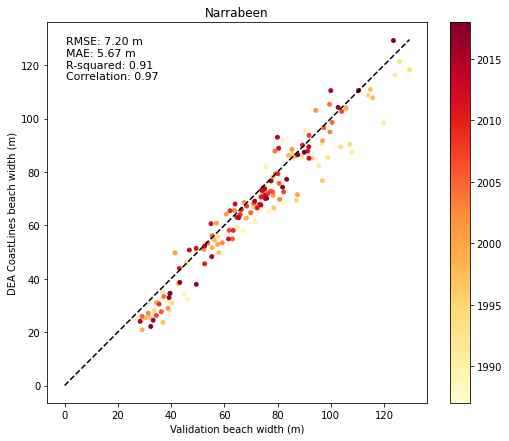

In [381]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from pathlib import Path
from shapely.geometry import Point, LineString

out_rmse = []

# for fname in glob.glob('output_data/*.csv'):
for fname in ['output_data/wrl_narrabeen.csv']:

    # Load validation data
    shoreline_dist = pd.read_csv(fname, parse_dates=['date'])
    
    # Get title for plot
    title = shoreline_dist.beach.iloc[0].capitalize()

    # Get bounding box to load data for
    minx, maxy = shoreline_dist.min().loc[['0_x', '0_y']]
    maxx, miny = shoreline_dist.max().loc[['0_x', '0_y']]
    bbox = gpd.GeoSeries(box(minx, miny, maxx, maxy), crs='EPSG:28356')

    # Import corresponding waterline contours
    contours_gdf = gpd.read_file(
        f'../packages/DEACoastLines_v0.2.0/DEACoastLines_coastlines_v0.2.0.shp',
        bbox=bbox).to_crs(epsg=28356)
    
    if len(contours_gdf.index) > 0:
    
        contours_gdf['year'] = contours_gdf.year.astype('int64')

        # Add year column
        shoreline_dist['year'] = shoreline_dist.date.dt.year

        # Aggregate by year and save count number
        counts = shoreline_dist.groupby(['year', 'site']).count().date
        shoreline_dist = shoreline_dist.groupby(['year', 'site']).median()
        shoreline_dist['n'] = counts
        shoreline_dist = shoreline_dist.reset_index()

        shoreline_geometry = shoreline_dist.apply(
            lambda x: LineString([(x.start_x, x.start_y), 
                                  (x.end_x, x.end_y)]), axis=1)

        shoreline_gdf = gpd.GeoDataFrame(shoreline_dist,
                                         geometry=shoreline_geometry,
                                         crs='EPSG:28356').reset_index()

        # Combine to match each shoreline contour to each date in validation data
        merge_test = shoreline_gdf.merge(contours_gdf,
                                         on='year',
                                         suffixes=('_val', '_deacl'))

        # For each row, compute distance between origin and location where 
        # profile intersects with waterline contour
        merge_test['DEA CoastLines beach width (m)'] = merge_test.apply(
            lambda x: x.geometry_val.intersection(x.geometry_deacl).hausdorff_distance(
                Point(x.start_x, x.start_y)),
            axis=1)
        merge_test = merge_test.rename({'0_dist': 'Validation beach width (m)'}, axis=1)
        merge_test = merge_test[merge_test['DEA CoastLines beach width (m)'] > 0]
        merge_test = merge_test[merge_test['Validation beach width (m)'] > 0]

        # Optional corrections
#         merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + 5

        # Calculate difference
        merge_test['Difference'] = (merge_test['Validation beach width (m)'] -
                                    merge_test['DEA CoastLines beach width (m)'])

        # Extract data to plot
        plot_df = merge_test[['Validation beach width (m)', 
                              'DEA CoastLines beach width (m)']]

        # Calculate stats
        rmse = mean_squared_error(merge_test['Validation beach width (m)'],
                                  merge_test['DEA CoastLines beach width (m)'])**0.5
        mae = mean_absolute_error(merge_test['Validation beach width (m)'],
                                  merge_test['DEA CoastLines beach width (m)'])
        r2 = r2_score(merge_test['Validation beach width (m)'],
                      merge_test['DEA CoastLines beach width (m)'])
        cor = plot_df.corr().iloc[0, 1]

        # Plot image
        fig, ax = plt.subplots(figsize=(8.5, 7))
        plot_df.plot.scatter(x='Validation beach width (m)',
                             y='DEA CoastLines beach width (m)',
                             c=merge_test.year,
                             s=15,
                             cmap='YlOrRd',
                             vmin=1987,
                             vmax=2018,
                             ax=ax)
        ax.plot(np.linspace(0, plot_df.max(axis=0).max()),
                np.linspace(0, plot_df.max(axis=0).max()),
                'black',
                linestyle='dashed')
        ax.set_title(title)
        ax.annotate(f'RMSE: {rmse:.2f} m\nMAE: {mae:.2f} m\nR-squared: {r2:.2f}\nCorrelation: {cor:.2f}', 
                    xy=(0.05, 0.85),
                    xycoords='axes fraction',
                    fontsize=11)

        # Export to file
        fig.savefig(f'figures/{Path(fname).stem}.png', 
                    bbox_inches='tight', 
                    dpi=150)
#         plt.cla()
#         plt.close(fig)
        
        out_rmse.append(rmse)

In [ ]:
merge_test

In [361]:
shoreline_dist

,year,site,start_x,start_y,end_x,end_y,0_dist,0_x,0_y,n,geometry
0,1988,narrabeen_all_pf1,342880.107890,6.269180e+06,343291.986672,6.268923e+06,90.373134,342956.763101,6.269132e+06,11,"LINESTRING (342880.108 6269180.364, 343291.987..."
1,1988,narrabeen_all_pf2,342732.895388,6.268784e+06,343161.902515,6.268571e+06,79.083969,342803.738425,6.268748e+06,11,"LINESTRING (342732.895 6268783.557, 343161.903..."
2,1988,narrabeen_all_pf4,342451.362695,6.267913e+06,342908.919210,6.267822e+06,81.932773,342531.713014,6.267897e+06,11,"LINESTRING (342451.363 6267913.117, 342908.919..."
3,1988,narrabeen_all_pf6,342460.817833,6.267043e+06,342920.268319,6.267111e+06,27.280702,342487.796843,6.267047e+06,11,"LINESTRING (342460.818 6267042.535, 342920.268..."
4,1988,narrabeen_all_pf8,342675.346674,6.266241e+06,343073.983065,6.266521e+06,49.383562,342715.766059,6.266269e+06,11,"LINESTRING (342675.347 6266240.960, 343073.983..."
...,...,...,...,...,...,...,...,...,...,...,...
150,2018,narrabeen_all_pf1,342880.107890,6.269180e+06,343291.986672,6.268923e+06,123.537500,342984.893380,6.269115e+06,22,"LINESTRING (342880.108 6269180.364, 343291.987..."
151,2018,narrabeen_all_pf2,342732.895388,6.268784e+06,343161.902515,6.268571e+06,87.600000,342811.367044,6.268745e+06,22,"LINESTRING (342732.895 6268783.557, 343161.903..."
152,2018,narrabeen_all_pf4,342451.362695,6.267913e+06,342908.919210,6.267822e+06,90.054545,342539.677922,6.267896e+06,22,"LINESTRING (342451.363 6267913.117, 342908.919..."
153,2018,narrabeen_all_pf6,342460.817833,6.267043e+06,342920.268319,6.267111e+06,32.398352,342492.857898,6.267047e+06,22,"LINESTRING (342460.818 6267042.535, 342920.268..."


In [360]:
merge_test

,index_val,year,site,start_x,start_y,end_x,end_y,Validation beach width (m),0_x,0_y,n,geometry_val,certainty,index_deacl,geometry_deacl,Landsat beach width (m),Difference
0,0,1988,narrabeen_all_pf1,342880.107890,6.269180e+06,343291.986672,6.268923e+06,90.373134,342956.763101,6.269132e+06,11,"LINESTRING (342880.108 6269180.364, 343291.987...",good,None,"MULTILINESTRING ((343200.000 6269460.567, 3432...",95.525251,-5.152117
1,1,1988,narrabeen_all_pf2,342732.895388,6.268784e+06,343161.902515,6.268571e+06,79.083969,342803.738425,6.268748e+06,11,"LINESTRING (342732.895 6268783.557, 343161.903...",good,None,"MULTILINESTRING ((343200.000 6269460.567, 3432...",65.917826,13.166144
2,2,1988,narrabeen_all_pf4,342451.362695,6.267913e+06,342908.919210,6.267822e+06,81.932773,342531.713014,6.267897e+06,11,"LINESTRING (342451.363 6267913.117, 342908.919...",good,None,"MULTILINESTRING ((343200.000 6269460.567, 3432...",68.284740,13.648033
3,3,1988,narrabeen_all_pf6,342460.817833,6.267043e+06,342920.268319,6.267111e+06,27.280702,342487.796843,6.267047e+06,11,"LINESTRING (342460.818 6267042.535, 342920.268...",good,None,"MULTILINESTRING ((343200.000 6269460.567, 3432...",25.166769,2.113933
4,4,1988,narrabeen_all_pf8,342675.346674,6.266241e+06,343073.983065,6.266521e+06,49.383562,342715.766059,6.266269e+06,11,"LINESTRING (342675.347 6266240.960, 343073.983...",good,None,"MULTILINESTRING ((343200.000 6269460.567, 3432...",50.126621,-0.743060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,2018,narrabeen_all_pf1,342880.107890,6.269180e+06,343291.986672,6.268923e+06,123.537500,342984.893380,6.269115e+06,22,"LINESTRING (342880.108 6269180.364, 343291.987...",good,None,"MULTILINESTRING ((342930.000 6264660.998, 3429...",129.217477,-5.679977
151,151,2018,narrabeen_all_pf2,342732.895388,6.268784e+06,343161.902515,6.268571e+06,87.600000,342811.367044,6.268745e+06,22,"LINESTRING (342732.895 6268783.557, 343161.903...",good,None,"MULTILINESTRING ((342930.000 6264660.998, 3429...",86.483461,1.116539
152,152,2018,narrabeen_all_pf4,342451.362695,6.267913e+06,342908.919210,6.267822e+06,90.054545,342539.677922,6.267896e+06,22,"LINESTRING (342451.363 6267913.117, 342908.919...",good,None,"MULTILINESTRING ((342930.000 6264660.998, 3429...",87.383889,2.670657
153,153,2018,narrabeen_all_pf6,342460.817833,6.267043e+06,342920.268319,6.267111e+06,32.398352,342492.857898,6.267047e+06,22,"LINESTRING (342460.818 6267042.535, 342920.268...",good,None,"MULTILINESTRING ((342930.000 6264660.998, 3429...",22.107971,10.290381


Text(0.1, 0.9, 'RMSE: 7.20 m\nMAE: 5.67 m\nR-squared: 0.91\nCorrelation: 0.97')

(array([ 0.,  0.,  3.,  4., 16., 11.,  8.,  9., 11.,  9.,  6.,  7.,  6.,
         2.,  6.,  4.,  4.,  4.,  2.,  0.,  4.,  0.,  1.,  2.,  0.,  0.,
         3.,  0.,  1.,  3.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  3.,
         0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <a list of 50 Patch objects>)

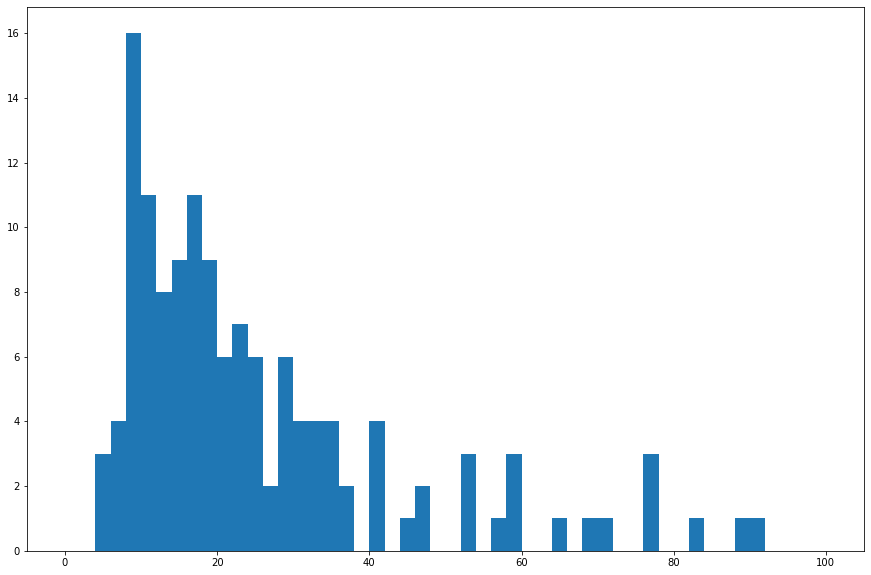

In [60]:
plt.figure(figsize = (15, 10))
plt.hist(out_rmse, range=(0, 100), bins=50)

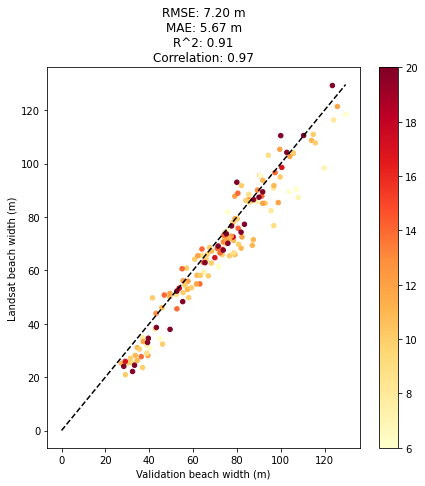

In [181]:
# Plot image
fig, ax = plt.subplots(figsize=(7, 7))
plot_df.plot.scatter(x='Validation beach width (m)',
                     y='Landsat beach width (m)',
                     c=merge_test.n,
                     s=20,
                     cmap='YlOrRd',
#                      vmin=1987,
                     vmax=20,
                     ax=ax)
ax.plot(np.linspace(0, plot_df.max(axis=0).max()),
        np.linspace(0, plot_df.max(axis=0).max()),
        'black',
        linestyle='dashed')
ax.set_title(f'RMSE: {rmse:.2f} m\nMAE: {mae:.2f} m\nR^2: {r2:.2f}\nCorrelation: {cor:.2f}');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2020